In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf 
import os 

import numpy as np  

SEED= 10491539
tf.random.set_seed(SEED)

cwd= os.getcwd() #get current working directory 

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.vgg16 import preprocess_input 

apply_data_augmentation  = True

if  apply_data_augmentation:
  train_datagen = ImageDataGenerator(             #data augmentation to modify the images at every epoch
  #width_shift_range = 0.3, 
  height_shift_range = 0.3,
  #vertical_flip=True,
  shear_range = 0.2,
  zoom_range = 0.3,
  horizontal_flip=True,
  rotation_range=10,
  fill_mode='constant',
  cval=0,
  rescale=1/255,   
  preprocessing_function=preprocess_input)
  
else:
  train_datagen = ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)
test_datagen= ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)

In [ ]:

#now I need to get the test images and associate them to the label contained in the json file 
import pandas as pd
import json
import sklearn
import numpy

json_path=os.path.join(r'\Users\Utente\Desktop\Polimi\Magistrale\2° anno\ANNDL_HW1\MaskDataset')

with open(os.path.join(json_path,"train_gt.json")) as j:
  tmp = json.load(j)

train_df = pd.DataFrame(tmp.items())
train_df.rename(columns = {0:'filename', 1:'class'}, inplace = True)
train_df["class"] = train_df["class"].astype(str)

train_df_shuffled=sklearn.utils.shuffle(train_df) 
l = len(train_df_shuffled)
train_df_shuffled=sklearn.utils.shuffle(train_df_shuffled)
training_df= train_df_shuffled[1800:]
validation_df= train_df_shuffled[:1799]   #about 30% of validation set
#training_df = np.random.choice(train_df_shuffled,(l-0.2*l))
#validation_df = np.random.choice(train_df_shuffled,(0.2*l))

print(validation_df,training_df)

       filename class
3630  13278.jpg     1
4715  12069.jpg     2
395   15132.jpg     0
3564  13510.jpg     1
3471  11553.jpg     1
...         ...   ...
1382  11859.jpg     0
103   11767.jpg     0
1835  10915.jpg     0
3877  11707.jpg     2
1549  10190.jpg     0

[1799 rows x 2 columns]        filename class
3612  14771.jpg     1
4512  17208.jpg     2
4607  13635.jpg     2
910   14955.jpg     0
3174  14235.jpg     1
...         ...   ...
5554  12823.jpg     2
4939  17389.jpg     2
5083  12793.jpg     2
3957  17400.jpg     2
3590  11519.jpg     1

[3814 rows x 2 columns]


In [ ]:
#Let's create the generators 

directory_training =os.path.join(r'\Users\Utente\Desktop\Polimi\Magistrale\2° anno\ANNDL_HW1\MaskDataset\training')


bs = 8

train_generator=train_datagen.flow_from_dataframe(
dataframe=training_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
class_mode="categorical",
)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=validation_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
class_mode="categorical",
)

Found 3814 validated image filenames belonging to 3 classes.
Found 1799 validated image filenames belonging to 3 classes.


In [ ]:
num_classes=3
img_h=256
img_w=256


train_dataset= tf.data.Dataset.from_generator(lambda:train_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes])) 

train_dataset=train_dataset.repeat()

validation_dataset= tf.data.Dataset.from_generator(lambda:valid_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes]))


validation_dataset=validation_dataset.repeat()


[]

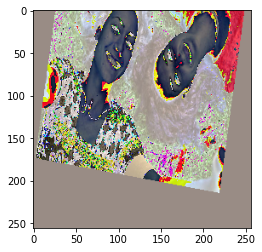

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

iterator= iter(train_dataset)

img , target = next(iterator)
img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

[]

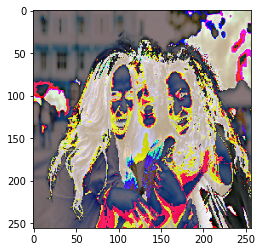

In [ ]:
%matplotlib inline

iterator= iter(validation_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:

from tensorflow.keras import regularizers

finetuning = True

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False
    
model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128, 
                                activation='relu',
                                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),    #regularizers to reduce overfitting
                                bias_regularizer=regularizers.l2(1e-4),
                                activity_regularizer=regularizers.l2(1e-5)))
model.add(tf.keras.layers.Dropout(0.2))       #dropout to reduce overfitting
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 387       
Total params: 14,780,739
Trainable params: 7,145,475
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
loss= tf.keras.losses.CategoricalCrossentropy()

lr= 1e-4

optimizer= tf.keras.optimizers.Adam(learning_rate=lr)

metrics=['accuracy']

model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

In [ ]:

from datetime import datetime

exps_dir = os.path.join(r'\Users\Utente\Desktop\Polimi\Magistrale\2° anno\ANNDL_HW1', 'transfer_learning_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_dir = os.path.join(exps_dir, 'CNN' + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

callbacks=[]

#early stopping callback
es_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,patience = 10) 
callbacks.append(es_callback)
    
#tensorboard

#tb_dir = os.path.join(r'\Users\Utente\Desktop\Polimi\Magistrale\2° anno\ANNDL_HW1')
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1) 
callbacks.append(tb_callback)

model.fit(x=train_dataset, 
          epochs=100,  #max number of epochs 
          steps_per_epoch=len(train_generator),
          validation_data= validation_dataset, 
          validation_steps=len(valid_generator),
          callbacks=callbacks )

Train for 239 steps, validate for 113 steps
Epoch 1/100
239/239 [==============================] - 66s 275ms/step - loss: 0.8947 - accuracy: 0.5593 - val_loss: 0.5810 - val_accuracy: 0.7582
Epoch 2/100
239/239 [==============================] - 60s 253ms/step - loss: 0.6242 - accuracy: 0.7255 - val_loss: 0.5021 - val_accuracy: 0.8105
Epoch 3/100
239/239 [==============================] - 60s 253ms/step - loss: 0.5401 - accuracy: 0.7701 - val_loss: 0.7226 - val_accuracy: 0.7054
Epoch 4/100
239/239 [==============================] - 60s 253ms/step - loss: 0.4963 - accuracy: 0.7905 - val_loss: 0.4486 - val_accuracy: 0.8243
Epoch 5/100
239/239 [==============================] - 60s 253ms/step - loss: 0.4518 - accuracy: 0.8191 - val_loss: 0.5368 - val_accuracy: 0.7738
Epoch 6/100
239/239 [==============================] - 61s 254ms/step - loss: 0.4093 - accuracy: 0.8340 - val_loss: 0.4847 - val_accuracy: 0.7960
Epoch 7/100
239/239 [==============================] - 61s 254ms/step - loss: 0.

In [ ]:
 test_dir =os.path.join(r'\Users\Utente\Desktop\Polimi\Magistrale\2° anno\ANNDL_HW1\MaskDataset\test')

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict_generator(test_gen, len(test_gen), verbose=1)


from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, r'\Users\Utente\Desktop\Polimi\Magistrale\2° anno\ANNDL_HW1\Results')

Found 450 images belonging to 1 classes.
450/450 [==============================] - 5s 12ms/step
